In [1]:
!pip install -q -U kaggle_environments

In [2]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns

from kaggle_environments import make, evaluate

C:\Users\ruslan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


termcolor not installed, skipping dependency
No pygame installed, ignoring import


In [3]:
import math


class BaseAgent():
    # Определение функции для получения результата раунда между двумя ходами
    def get_score(left_move, right_move):
        # Разница между двумя ходами, если сумма ходов чётная, то победа ведёт к игроку, иначе к противнику
        delta = (
            right_move - left_move  # Разница при чётной сумме ходов
            # Проверка на чётность суммы двух ходов
            if (left_move + right_move) % 2 == 0
            else left_move - right_move  # Разница при нечётной сумме ходов
        )
        # Возвращаем 0 при ничьей (delta == 0), иначе возвращаем 1 если победили -1 если проиграли
        return 0 if delta == 0 else math.copysign(1, delta)

Список агентов и основные настройки

Агенты которые сейчас доступны
- `rock_agent` - Простой агент всегда выберет (камень)
- `paper_agent` - Простой агент всегда выберет (бумага)
- `scissors_agent` - Простой агент всегда выберет (ножницы)
- `copy_opponent` - Агент копирует последнее действие оппонента
- `counter_reactionary` - Агент который меняет свои действия на основе исходов предыдущих ходов. Если выиграл меняем на следующие действия противника 
- `fail_random` - Агент который меняет свое действия после проигрыша случайным образом. После проигрыша выбираем случайное действия
- `enemy_actions` - Алгоритм зеркальных действий но мы повторяем не предыдущий а ход который противник делал 2 хода назад
- `zero_one_two` - который чередует действия 0 -> 1 -> 2 -> 0 и так далее
- `random` - Случайный агент
- `conquering_oneself` - Побеждающий себя если проиграл или ничья каждый следующий ход делает таким который победил бы себя на предыдущем
- `majority_based` - Использующий стратегию анализа на основе большинства. Каждый следующий ход делает таким, который победил бы его собственный предыдущий ход
- `change_after_victory` - Смена после победы

#Таблица возможных значений

| Id    | Symbol |
| -------- | ------- |
| 0 | Rock - Камень |
| 1 | Paper - Бумага |
| 2 | Scissors - Ножници |

In [4]:
%%writefile rock_agent.py
#Example of the simple agent
#0 - rock
#1 - paper
#2 - scissors

# Агент№1, Простой агент всегда выберет (камень)
def rock_agent(observation, configuration):
    return 0

Overwriting rock_agent.py


In [5]:
%%writefile paper_agent.py
# Агент№2, Простой агент всегда выберет (бумага)
def paper_agent(observation, configuration):
    return 1

Overwriting paper_agent.py


In [6]:
%%writefile scissors_agent.py

# Агент№3, Простой агент всегда выберет (ножницы)
def scissors_agent(observation, configuration):
    return 2

Overwriting scissors_agent.py


In [7]:
%%writefile copy_opponent.py
import random

# Агент№4, Агент копирует последнее действие оппонента
def copy_opponent(observation, configuration):
    #in case we have information about opponent last move
    if observation.step > 0:
        return observation.lastOpponentAction
    #initial step
    else:
        return random.randrange(0, configuration.signs)

Overwriting copy_opponent.py


In [8]:
%%writefile counter_reactionary.py
import random

from utils_class import BaseAgent 

# Агент№5, Агент который меняет свои действия на основе исходов предыдущих ходов
# Если выиграл меняем на следующие действия противника 
class CounterReactionaryAgent(BaseAgent):
    def __init__(self):
        self.last_action = None  # Последнее действие агента

    def play(self, observation, configuration):
        if observation['step'] == 0:  # Если первый раунд
            # Выбирает случайное действие
            self.last_action = random.randint(0, 2)  
        # Если агент выиграл
        elif self.get_score(self.last_action, observation.lastOpponentAction) == 1:
            # Выбирает следующее действие противника
            self.last_action = (observation.lastOpponentAction + 1) % 3
        else:
            # Если проиграл или была ничья, меняет действие через одно
            self.last_action = (self.last_action + 2) % 3
        return self.last_action

# Создание объекта агента
agent = CounterReactionaryAgent()

# Основная функция для запуска агента
def run(observation, configuration):
    # Запускаем метод play для выполнения хода
    return agent.play(observation, configuration)


Overwriting counter_reactionary.py


In [9]:
%%writefile fail_random.py
import random
from utils_class import BaseAgent 

# Агент№6, Агент который меняет свое действия после проигрыша случайным образом
# После проигрыша выбираем случайное действия
class FailRandomAgent(BaseAgent):
    def __init__(self):
        self.last_action = None  # Последнее действие агента

    def play(self, observation, configuration):
        if observation['step'] == 0:  # Если первый раунд
            # Выбирает случайное действие
            self.last_action = random.randint(0, 2)  
        # Если проиграл или ничья
        elif self.get_score(self.last_action, observation.lastOpponentAction) != 1:
            # Если проиграл выбираем случайное действия не равное текущим
            self.last_action = (self.last_action + random.randint(1, 2)) % 3
        return self.last_action

# Создание объекта агента
agent = FailRandomAgent()

# Основная функция для запуска агента
def run(observation, configuration):
    # Запускаем метод play для выполнения хода
    return agent.play(observation, configuration)

Overwriting fail_random.py


In [10]:
%%writefile enemy_actions.py
import random
from utils_class import BaseAgent 


# Агент№7, Алгоритм зеркальных действий но мы повторяем не предыдущий 
# а ход который противник делал 2 хода назад
class EnemyActionsAgent(BaseAgent):
    def __init__(self):
        self.enemy_actions = []  # массив действий пользователя
        self.action = None  # наше действие для удобства вынесено в отдельную переменную

    def play(self, observation, configuration):
        if observation['step'] < 2:  # Если первый раунд
            # Выбирает случайное действие
            self.action = random.randint(0, 2)
            # Записываем первые действия случайны
            self.enemy_actions.insert(0, self.action)
        else:
            # Записываем действия противника в начало
            self.enemy_actions.insert(0, observation.lastOpponentAction)
            # Берем действия противника два которое он совершил несколько ходов назад
            self.action = self.enemy_actions.pop(len(self.enemy_actions) - 1)
        return self.action

# Создание объекта агента
agent = EnemyActionsAgent()

# Основная функция для запуска агента
def run(observation, configuration):
    # Запускаем метод play для выполнения хода
    return agent.play(observation, configuration)

Overwriting enemy_actions.py


In [11]:
%%writefile zero_one_two.py
import random
from utils_class import BaseAgent 


# Агент№8, Агент который чередует действия 0 -> 1 -> 2 -> 0 и так далее
class ZeroOneTwoAgent(BaseAgent):
    def play(self, observation, configuration):
        return (observation['step'] + 2) % 3  # Чередует действия по кругу

# Создание объекта агента
agent = ZeroOneTwoAgent()

# Основная функция для запуска агента
def run(observation, configuration):
    # Запускаем метод play для выполнения хода
    return agent.play(observation, configuration)

Overwriting zero_one_two.py


In [12]:
%%writefile random.py
import random
from utils_class import BaseAgent 


# Агент№9, Случайный агент
class RandomAgent(BaseAgent):
    def play(self, observation, configuration):
        return random.randint(0, 2) % 3  # Генерируем случайное число

# Создание объекта агента
agent = RandomAgent()

# Основная функция для запуска агента
def run(observation, configuration):
    # Запускаем метод play для выполнения хода
    return agent.play(observation, configuration)

Overwriting random.py


In [13]:
%%writefile conquering_oneself.py
import random
from utils_class import BaseAgent 


# Агент№10, Побеждающий себя если проиграл или ничья
# каждый следующий ход делает таким который победил бы себя на предыдущем
class ConqueringOneselfAgent(BaseAgent):
    def __init__(self):
        self.last_action = None  # Последнее действие агента

    def play(self, observation, configuration):
        if observation['step'] == 0:  # Если первый раунд
            # Выбирает случайное действие
            self.last_action = random.randint(0, 2)  
        # Если проиграл или ничья
        elif self.get_score(self.last_action, observation.lastOpponentAction) != 1:
            # Если проиграл меняем на следующее действие от своего
            self.last_action = (self.last_action + 1) % 3
        return self.last_action

# Создание объекта агента
agent = ConqueringOneselfAgent()

# Основная функция для запуска агента
def run(observation, configuration):
    # Запускаем метод play для выполнения хода
    return agent.play(observation, configuration)

Overwriting conquering_oneself.py


In [14]:
%%writefile majority_based.py
from utils_class import BaseAgent
import random

# Агент №11, Использующий стратегию анализа на основе большинства
# Каждый следующий ход делает таким, который победил бы его собственный предыдущий ход
class MajorityBasedAgent(BaseAgent):
    def __init__(self):
        self.last_action = None  # Последнее действие агента (инициализация)
        # Статистика ходов противника
        self.statistic = {0: 0, 1: 0, 2: 0}

    def play(self, observation, configuration):
        # Если это не первый раунд, собираем статистику ходов противника
        if observation['step'] != 0:
            self.add_statistic(observation.lastOpponentAction)
        # Если это первый раунд, выбираем случайное действие
        if observation['step'] == 0:
            # Случайный выбор между камнем, ножницами и бумагой
            self.last_action = random.randint(0, 2)
        # Если агент проиграл или сыграл вничью
        elif self.get_score(self.last_action, observation.lastOpponentAction) != 1:
            # Сортируем статистику ходов противника по убыванию частоты использования
            target_action_list = sorted(
                self.statistic.items(), key=lambda item: item[1], reverse=True)
            # Выбираем ход, который победит наиболее часто используемый противником ход
            self.last_action = (target_action_list[0][0] + 1) % 3
        return self.last_action  # Возвращаем выбранное действие

    # Добавляем ход противника в статистику
    def add_statistic(self, lastOpponentAction):
        if lastOpponentAction not in self.statistic:  # Если ход противника не записан в статистику
            self.statistic[lastOpponentAction] = 0  # Инициализируем его
        # Увеличиваем счетчик данного хода
        self.statistic[lastOpponentAction] += 1


# Создание объекта агента
agent = MajorityBasedAgent()

# Основная функция для запуска агента
def run(observation, configuration):
    # Запускаем метод play для выполнения хода
    return agent.play(observation, configuration)

Overwriting majority_based.py


In [15]:
%%writefile change_after_victory.py
import random
from utils_class import BaseAgent 


# Агент№12, Смена после победы
class ChangeAfterVictoryAgent(BaseAgent):
    def __init__(self):
        self.last_action = None  # Последнее действие агента

    def play(self, observation, configuration):
        if observation['step'] == 0:  # Если первый раунд
            # Выбирает случайное действие
            self.last_action = random.randint(0, 2)  
        # Если проиграл или ничья
        elif self.get_score(self.last_action, observation.lastOpponentAction) == 1:
            # Если проиграл меняем на следующее действие от своего
            self.last_action = (self.last_action + 1) % 3
        return self.last_action

# Создание объекта агента
agent = ChangeAfterVictoryAgent()

# Основная функция для запуска агента
def run(observation, configuration):
    # Запускаем метод play для выполнения хода
    return agent.play(observation, configuration)

Overwriting change_after_victory.py


In [16]:
# Код используется для тестирования и отладки отдельных агентов
evaluate(
    "rps",  # Среда игры "Камень, ножницы, бумага" (Rock, Paper, Scissors) - не требует изменения
    ["majority_based.py", "reactionary"],  # Список агентов для тестирования 
    configuration={"episodeSteps": 100},  # Количество раундов (эпизодов)
    debug=True,  # Включение режима отладки для вывода дополнительной информации во время выполнения
)

[[-49.0, 49.0]]

In [17]:
# Код используется для тестирования, позволяет визуализировать процесс игры, 
# что поможет проверить, нормально ли работает агент
env = make("rps", configuration={"episodeSteps": 100})  
# Запуск игры с двумя агентами
env.run(["majority_based.py", "reactionary"])  
# Визуализация игры в формате ipython с заданной шириной и высотой экрана
env.render(mode="ipython", width=500, height=400)  


[[-999.0, 999.0]]s paper_agent
[[999.0, -999.0]]s scissors_agent
[[0, 0]]k_agent vs copy_opponent
[[-996.0, 996.0]]s counter_reactionary
[[-994.0, 994.0]]s fail_random
[[0, 0]]k_agent vs enemy_actions
[[0, 0]]k_agent vs zero_one_two
[[0, 0]]k_agent vs random
[[-996.0, 996.0]]s conquering_oneself
[[-997.0, 997.0]]s majority_based
[[997.0, -997.0]]s change_after_victory

[[-999.0, 999.0]]vs scissors_agent
[[0, 0]]er_agent vs copy_opponent
[[-996.0, 996.0]]vs counter_reactionary
[[-997.0, 997.0]]vs fail_random
[[0, 0]]er_agent vs enemy_actions
[[0, 0]]er_agent vs zero_one_two
[[64.0, -64.0]]t vs random
[[-998.0, 998.0]]vs conquering_oneself
[[-999.0, 999.0]]vs majority_based
[[0, 0]]er_agent vs change_after_victory

[[0, 0]]ssors_agent vs copy_opponent
[[-996.0, 996.0]]nt vs counter_reactionary
[[-996.0, 996.0]]nt vs fail_random
[[0, 0]]ssors_agent vs enemy_actions
[[0, 0]]ssors_agent vs zero_one_two
[[24.0, -24.0]]gent vs random
[[-998.0, 998.0]]nt vs conquering_oneself
[[-999.0, 999.0]]

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0, 0.5, 'rock_agent'),
  Text(0, 1.5, 'paper_agent'),
  Text(0, 2.5, 'scissors_agent'),
  Text(0, 3.5, 'copy_opponent'),
  Text(0, 4.5, 'counter_reactionary'),
  Text(0, 5.5, 'fail_random'),
  Text(0, 6.5, 'enemy_actions'),
  Text(0, 7.5, 'zero_one_two'),
  Text(0, 8.5, 'random'),
  Text(0, 9.5, 'conquering_oneself'),
  Text(0, 10.5, 'majority_based'),
  Text(0, 11.5, 'change_after_victory')])

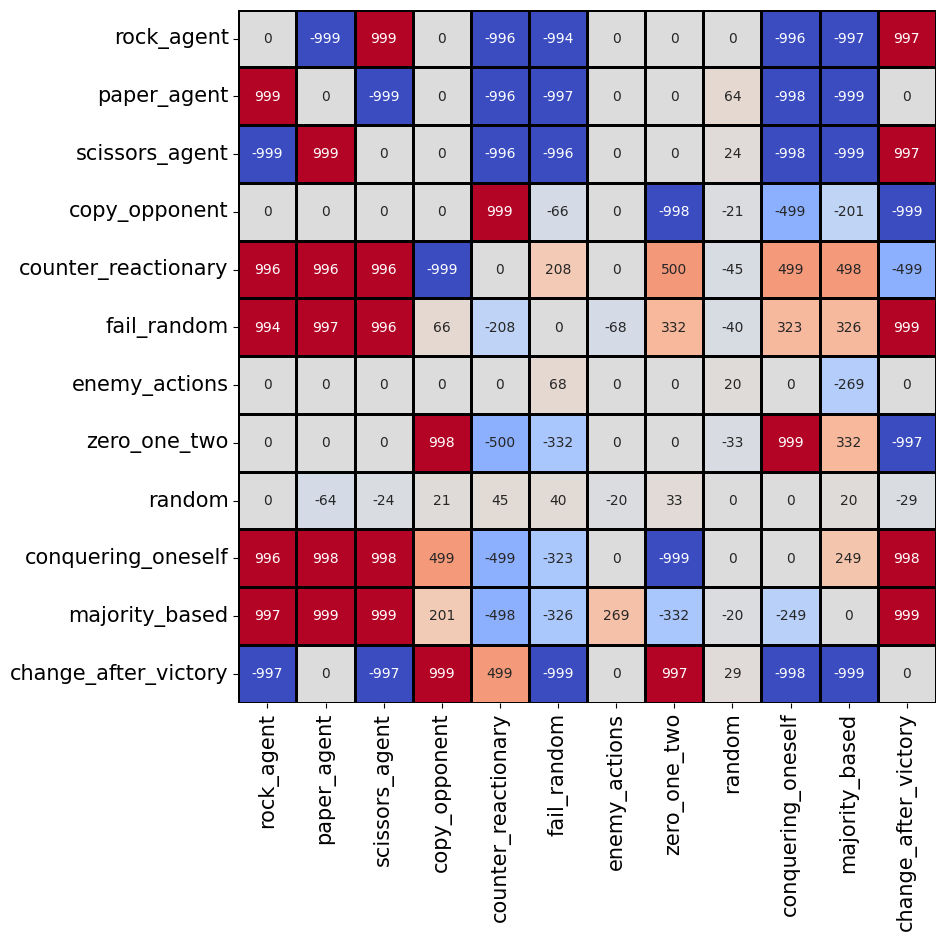

In [18]:
# Список имен агентов, которые будут участвовать в соревновании
list_names = [
    "rock_agent",
    "paper_agent",
    "scissors_agent",
    "copy_opponent",
    "counter_reactionary",
    "fail_random",
    "enemy_actions",
    "zero_one_two",
    "random",
    "conquering_oneself",
    "majority_based",
    "change_after_victory",
]

# Генерация списка файлов агентов на основе их имен, добавляя к каждому имя `.py`
list_agents = [agent_name + ".py" for agent_name in list_names]

# Определяем количество агентов в списке
n_agents = len(list_names)

# Создаем матрицу для хранения результатов игр, инициализируем её нулями
scores = np.zeros((n_agents, n_agents), dtype=np.int64)

# Цикл по каждому агенту для создания пар и проведения игр
for ind_agent_1 in range(len(list_names)):
    # Внутренний цикл для создания пар агентов, начиная с agenta_1 и далее
    for ind_agent_2 in range(ind_agent_1 + 1, len(list_names)):
        # Логгируем текущую пару агентов, которые сражаются друг с другом
        print(
            f"LOG: {list_names[ind_agent_1]} vs {
                list_names[ind_agent_2]}",  # Выводим, кто с кем играет
            end="\r"
        )
        # Оценка игры между двумя агентами
        current_score = evaluate(
            "rps",
            [list_agents[ind_agent_1], list_agents[ind_agent_2]],
            configuration={"episodeSteps": 1000},
            debug=True
        )
        print(current_score)

        # Сохраняем результаты в матрицу
        scores[ind_agent_1, ind_agent_2] = current_score[0][0]
        scores[ind_agent_2, ind_agent_1] = current_score[0][1]

    print()

# Преобразуем результаты игр в DataFrame для удобной работы и визуализации
df_scores = pd.DataFrame(
    scores,  
    index=list_names,
    columns=list_names,
)

# Определяем размер фигуры для тепловой карты
plt.figure(figsize=(9, 9))

# Создаем тепловую карту результатов с использованием библиотеки Seaborn
sns.heatmap(
    df_scores, annot=True, cbar=False,
    # Задаем цветовую схему (теплая и холодная) и ширину линий между ячейками
    cmap='coolwarm', linewidths=1,
    # Цвет линий между ячейками черный, формат чисел целочисленный
    linecolor='black', fmt="d",
)

# Настраиваем метки на оси X (горизонтально) и Y (вертикально)
# Поворот меток на оси X на 90 градусов, шрифт увеличен до 15
plt.xticks(rotation=90,fontsize=15)
plt.yticks(rotation=0,fontsize=15)


Воспользуемся функцией evaluate из библиотеки kaggle_environments с помощью которой запустим наших агентов и проведем эксперимент на заданном количестве игр
